In [1]:
import torch

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize

from tqdm import tqdm

from data.loader import load_amazon
from modules.rq_vae import RQ_VAE

c:\Users\Justin\Documents\Master-Thesis\RQ-VAE\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
batch_size = 32
normalize_data = True
train_loader, data_clean = load_amazon(category='beauty', batch_size=batch_size, normalize_data=normalize_data)

input_dimension = data_clean.shape[1]
hidden_dimension = [input_dimension, 512, 256]
latent_dimension = 128

num_codebook_layers = 3
codebook_clusters = 256
commitment_weight = 0.25

learning_rate = 1e-3
weight_decay = 1e-5
num_epochs = 1000

In [3]:
model = RQ_VAE(
        input_dim = input_dimension,
        latent_dim = latent_dimension,
        hidden_dims = hidden_dimension,
        codebook_size = codebook_clusters,
        codebook_kmeans_init = True,
        codebook_sim_vq = True,
        n_quantization_layers = num_codebook_layers,
        commitment_weight = commitment_weight,
)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model.kmeans_init_codebooks(torch.tensor(data_clean))

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [10]:
def train(model, train_loader, optimizer, num_epochs):
    model.train()
    
    epoch_progress = tqdm(range(num_epochs), total=num_epochs, desc="Training")
    results = []
    
    for epoch in epoch_progress:
        total_loss = 0
        total_reconstruction_loss = 0
        total_commit_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device).float()
            optimizer.zero_grad()
            result = model(batch)
            result.loss.backward()
            optimizer.step()
            
            total_loss += result.loss.item()
            total_reconstruction_loss += result.reconstruction_loss.item()
            total_commit_loss += result.rqvae_loss.item()
        epoch_stats = {"Epoch": epoch,
                        "Loss": total_loss / len(train_loader),
                        "Reconstruction Loss": total_reconstruction_loss / len(train_loader),
                        "Commitment Loss": total_commit_loss / len(train_loader)}
        epoch_progress.set_postfix(Loss=epoch_stats["Loss"])
        results.append(epoch_stats)
    return results

In [11]:
losses = train(model, train_loader, optimizer, num_epochs)

Training: 100%|██████████| 1000/1000 [48:33<00:00,  2.91s/it, Loss=5.46e+7]


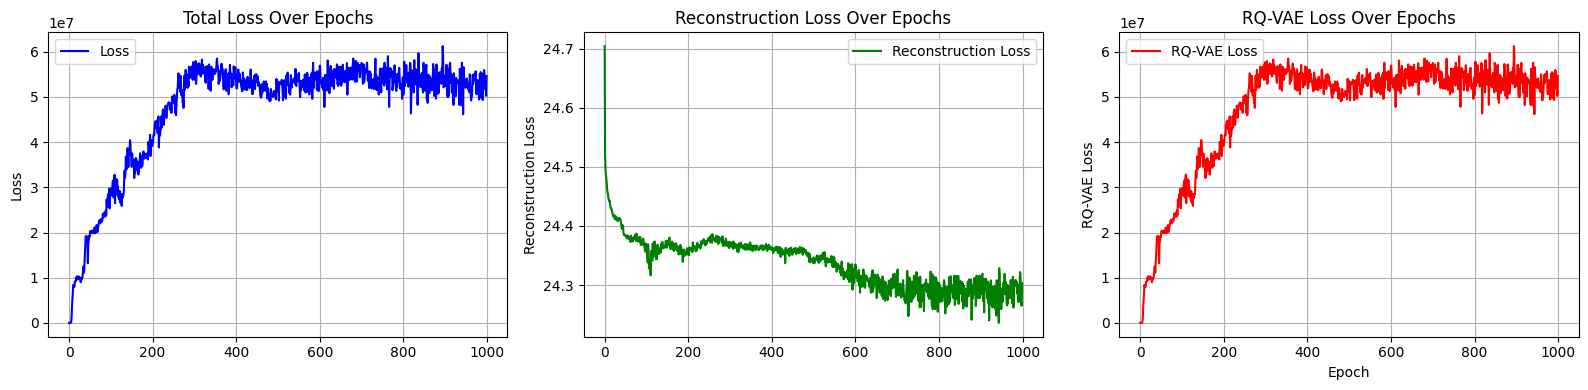

In [17]:
from matplotlib import pyplot as plt


fig, axs = plt.subplots(1, 3, figsize=(16, 4), sharex=True)
# Loss
axs[0].plot(
    [item['Epoch'] for item in losses],
    [item['Loss'] for item in losses],
    label='Loss',
    color='blue'
)
axs[0].set_ylabel("Loss")
axs[0].set_title("Total Loss Over Epochs")
axs[0].legend()
axs[0].grid(True)

# RQ-VAE Loss
axs[1].plot(
    [item['Epoch'] for item in losses],
    [item['Reconstruction Loss'].cpu().item() if hasattr(item['Reconstruction Loss'], 'cpu') else item['Reconstruction Loss'] for item in losses],
    label='Reconstruction Loss',
    color='green'
)
axs[1].set_ylabel("Reconstruction Loss")
axs[1].set_title("Reconstruction Loss Over Epochs")
axs[1].legend()
axs[1].grid(True)

# Reconstruction Loss
axs[2].plot(
    [item['Epoch'] for item in losses],
    [item['Commitment Loss'].cpu().item() if hasattr(item['Commitment Loss'], 'cpu') else item['Commitment Loss'] for item in losses],
    label='RQ-VAE Loss',
    color='red'
)
axs[2].set_xlabel("Epoch")
axs[2].set_ylabel("RQ-VAE Loss")
axs[2].set_title("RQ-VAE Loss Over Epochs")
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


In [22]:
sem_ids = []

for datapoint in tqdm(data_clean, desc="Getting semantic ids"):
    song = torch.tensor(datapoint).to(device).float()
    
    with torch.no_grad():
        sem_id = model.get_semantic_ids(song).sem_ids
        sem_ids.append(sem_id)
        
sem_ids_cpu = [tensor.cpu() for tensor in sem_ids]
sem_ids_cpu = np.array(sem_ids_cpu)[:,0,:]
np.unique([x.cpu() for x in sem_ids], axis=0, return_counts=True)

Getting semantic ids:   0%|          | 0/12101 [00:00<?, ?it/s]c:\Users\Justin\Documents\Master-Thesis\RQ-VAE\modules\quantization.py:64: UserWarning: Using a target size (torch.Size([1, 128])) that is different to the input size (torch.Size([128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, quantized.detach()) + self.commitment_weight * F.mse_loss(quantized, x.detach())
c:\Users\Justin\Documents\Master-Thesis\RQ-VAE\modules\quantization.py:64: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([1, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(x, quantized.detach()) + self.commitment_weight * F.mse_loss(quantized, x.detach())
Getting semantic ids:   0%|          | 0/12101 [00:00<?, ?it/s]


EinopsError:  Error while processing rearrange-reduction pattern "b h d -> h d b".
 Input tensor shape: torch.Size([3, 128]). Additional info: {}.
 Wrong shape: expected 3 dims. Received 2-dim tensor.